In [200]:
import scipy
import sklearn
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import math as m
import pandas as pd
import os
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
import csv
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import signal, ndimage
from scipy.io.wavfile import read
from scipy.signal import periodogram
from scipy.ndimage import median_filter
from matplotlib import pyplot
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from python_speech_features import mfcc
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from google.colab import drive ## If running on google colab
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC,LinearSVC

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def segment_cough(x,fs, cough_padding=0.1,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask


In [ ]:

filepath='/content/drive/MyDrive/Colab Notebooks/prosjektOppgaveHoost/public_dataset_Unzipped/public_dataset/'
df = pd.read_csv(filepath + 'metadata_compiled.csv')
names_to_convert = df.uuid.to_numpy()
with open(filepath + 'metadata_compiled.csv', 'rt') as f:
    reader = csv.reader(f)
    public_data = list(reader)

In [221]:

dst_C_H='/content/drive/MyDrive/Colab Notebooks/prosjektOppgaveHoost/public_dataset_Unzipped/verified_wav_COVID_HEALTHY/'
all_features=[0]*78
features=[]
labelVector=[]
feature_filename=[]
COVID=1
HEALTHY=0
s=0
index_name=public_data[0].index('uuid')
index_status=public_data[0].index('status')
for filename in os.listdir(dst_C_H):
  if os.path.isfile(dst_C_H+filename):
    if (filename[-4:])==".wav":
      all_segments=[]
      features=[]
      mfcc_feat=[]
      mfcc_std=[]
      mfcc_mean=[]
      delta_feat=[]
      delta_mean=[]
      delta_std=[]
      delta_delta_feat=[]
      delta_delta_mean=[]
      delta_delta_std=[]
      f_down=20000
      fs, signal = wav.read(dst_C_H+filename)
      down=scipy.signal.decimate(signal, 2) #downsampling
      norm=2.*(down - np.min(down))/np.ptp(down)-1 #normalizing
      segment,mask=segment_cough(norm,f_down, cough_padding=0.1,min_cough_len=0.1, th_l_multiplier = 0.00000001, th_h_multiplier = 0.000002)
      if len(segment)>1:
        for line in segment:
          all_segments=np.append(all_segments,line) #all the segments in one row from each file, one segment=one cough 
      elif len(segment)==1:
        all_segments=np.array(segment[0])
      mfcc_feat=mfcc(all_segments,samplerate=f_down,winlen=0.025, winstep=0.01, numcep=13, lowfreq=0, highfreq=10000)
      #print(mfcc_feat.shape)
      mfcc_mean=mfcc_feat.mean(axis=0)
      #print(mfcc_mean[0])
      mfcc_std=mfcc_feat.std(axis=0)
      #print(mfcc_std[0])
      delta_feat=delta(mfcc_feat,2)
      delta_mean=delta_feat.mean(axis=0)
      delta_std=delta_feat.std(axis=0)
      delta_delta_feat=delta(delta_feat,2)
      delta_delta_mean=delta_delta_feat.mean(axis=0)
      #print(delta_delta_mean[0])
      delta_delta_std=delta_delta_feat.std(axis=0)
      features.append(mfcc_mean)
      features.append(mfcc_std)
      features.append(delta_mean)
      features.append(delta_std)
      features.append(delta_delta_mean)
      features.append(delta_delta_std)
      features_flat_list=[]
      for i in range(6):
        for j in range(13):
          features_flat_list.append(features[i][j])
      all_features=np.vstack((all_features,features_flat_list))
      for i in range(1,len(public_data)):
        if public_data[i][index_name]==filename[:36]:
          if public_data[i][index_status]=='COVID-19':
            labelVector.append(COVID)
          elif public_data[i][index_status]=='healthy':
            labelVector.append(HEALTHY)
      feature_filename.append(filename)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: WavFileWarning: Reached EOF prematurely; finished at 393216 bytes, expected 956238 bytes from header.


In [223]:
all_Features=all_features[1:][:] #remove the zeros in the beginning
print(all_Features.shape)
print(len(labelVector))
print(len(feature_filename))
print(all_Features)

(1270, 78)
1270
1270
[[-5.90237471  6.96195657 -1.02203883 ...  0.99949808  1.06252649
   0.94892815]
 [-4.63261706 14.27575969 -3.62142677 ...  0.92095601  1.03244177
   0.91029598]
 [-6.13087923  8.31417478 -0.28729853 ...  0.96745356  0.77489831
   0.70837296]
 ...
 [-7.04196348 11.19532676  1.00087839 ...  0.846076    0.98039494
   0.70823265]
 [-7.18191149  9.83627494 -2.54910039 ...  0.80276613  0.86239416
   0.69793116]
 [-7.91891116  8.02625397 -3.16681867 ...  0.89494297  1.05719039
   0.86757777]]


In [224]:
filename_feature= np.column_stack((feature_filename,all_Features))
metadata_features=np.column_stack((filename_feature,labelVector))
os.chdir('/content/drive/MyDrive/Colab Notebooks/prosjektOppgaveHoost/public_dataset_Unzipped')
pd.DataFrame(metadata_features).to_csv('features_2_wp.csv')

In [228]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scalerAndFit=scaler.fit_transform(all_Features)
X=scalerAndFit
y=labelVector
print(X.shape)
print(len(labelVector))

(1270, 78)
1270


Training SVM


In [253]:
#Grid search SVC
model = SVC(cache_size=2000)
gamma_range = np.logspace(-10,10,5,base=2)
C_range = np.logspace(-10,10,5,base=2)
param_grid = dict(gamma=gamma_range, C = C_range, kernel=['rbf'],tol=[0.001])
#param_grid = dict(gamma=[0.00909765625], C = [32], kernel=['rbf'],tol=[0.001])
#model = SVC(C=32,gamma=0.00909765625,kernel='rbf',tol=0.001)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   39.0s finished


Best: 0.563780 using {'C': 1.0, 'gamma': 0.0009765625, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.0009765625, 'gamma': 0.0009765625, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.0009765625, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.0009765625, 'gamma': 1.0, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.0009765625, 'gamma': 32.0, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.0009765625, 'gamma': 1024.0, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.03125, 'gamma': 0.0009765625, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.03125, 'gamma': 1.0, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.03125, 'gamma': 32.0, 'kernel': 'rbf', 'tol': 0.001}
0.545669 (0.003608) with: {'C': 0.03125, 'gamma': 1024.0, 'kernel': 'rbf', 'tol': 0.

10-fold CROSS-validation manually


In [255]:
#X = xn
#y = np.array(labelVector_int)
X.shape
conf_matrix_list_of_arrays = []
X_test=np.zeros((127,78))
X_train=np.zeros((1143,78))
Y_test=[0]*127
Y_train=[0]*1143
for i in range(0,9):
  X_test[:][:]=X[i*127:127*(i+1)][:]
  Y_test[:]=y[i*127:127*(i+1)]
  #print(X_test[0][0])
  if i==0:
    X_train[:][:]=X[127:][:]
    Y_train[:]=y[127:]
    #print(X_train.shape)
  elif i>0 or i<9:
    X_train=np.vstack((X[0:127*(i)][:],X[127*(i+1):][:]))
    #Y_train=np.vstack((y[0:127*(i)],y[127*(i+1):]))
    Y_train[:]=np.append(y[0:127*(i)],y[127*(i+1):])
    #print(X_train.shape)
  else:
    X_train[:][:]=X[127*i][:]
    Y_train[:][:]=y[127*i][:]
  clf_svm = SVC(C=1.0,gamma=0.0009765625,kernel='rbf',tol=0.001)
  clf_svm.fit(X_train,Y_train)
  conf_matrix = confusion_matrix(Y_test, clf_svm.predict(X_test))
  conf_matrix_list_of_arrays.append(conf_matrix)


In [256]:
print(conf_matrix_list_of_arrays)
#for i in range(len(conf_matrix_list_of_arrays)):


[array([[68,  8],
       [41, 10]]), array([[70,  4],
       [47,  6]]), array([[63,  7],
       [46, 11]]), array([[53,  5],
       [59, 10]]), array([[60, 15],
       [42, 10]]), array([[61,  8],
       [48, 10]]), array([[60, 11],
       [47,  9]]), array([[66,  5],
       [43, 13]]), array([[62,  5],
       [48, 12]])]


In [257]:
y_pred_svm = cross_val_predict(clf_svm ,X,y,cv=5)

In [258]:
print(classification_report(y,y_pred_svm))

              precision    recall  f1-score   support

           0       0.56      0.89      0.69       693
           1       0.57      0.17      0.26       577

    accuracy                           0.56      1270
   macro avg       0.56      0.53      0.48      1270
weighted avg       0.56      0.56      0.50      1270



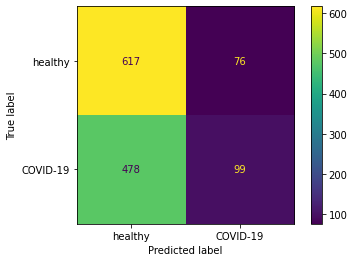

In [259]:
cm_svm = confusion_matrix(y,y_pred_svm)
display_labels=['healthy','COVID-19']
ConfusionMatrixDisplay(cm_svm,display_labels=display_labels).plot(values_format='.0f')

XGBoost Classifier



In [261]:
from xgboost import XGBClassifier

In [262]:
# grid search
model = XGBClassifier()
n_estimators = [200,600,800,1000]
max_depth = [2, 4, 6,8]
learning_rate = [0.01]
gamma = [0]
reg_lambda = [1]
alpha = [0]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate,gamma=gamma,reg_lambda=reg_lambda,alpha=alpha)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))


[2, 4, 6, 8]
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 13.8min finished


Best: 0.473253 using {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'reg_lambda': 1}
0.397500 (0.038331) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 1}
0.422311 (0.049212) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 600, 'reg_lambda': 1}
0.436599 (0.053019) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 800, 'reg_lambda': 1}
0.434718 (0.054244) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'reg_lambda': 1}
0.420326 (0.062397) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1}
0.444642 (0.042817) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'reg_lambda': 1}
0.441789 (0.045459) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 8

In [263]:
conf_matrix_list_of_arrays = []
X_test=np.zeros((127,78))
X_train=np.zeros((1143,78))
Y_test=[0]*127
Y_train=[0]*1143
for i in range(0,9):
  X_test[:][:]=X[i*127:127*(i+1)][:]
  Y_test[:]=y[i*127:127*(i+1)]
  #print(X_test[0][0])
  if i==0:
    X_train[:][:]=X[127:][:]
    Y_train[:]=y[127:]
    #print(X_train.shape)
  elif i>0 or i<9:
    X_train=np.vstack((X[0:127*(i)][:],X[127*(i+1):][:]))
    #Y_train=np.vstack((y[0:127*(i)],y[127*(i+1):]))
    Y_train[:]=np.append(y[0:127*(i)],y[127*(i+1):])
    #print(X_train.shape)
  else:
    X_train[:][:]=X[127*i][:]
    Y_train[:][:]=y[127*i][:]
  xgbc = XGBClassifier(learning_rate=0.01,gamma=0,max_depth=8,n_estimators=1000)
  rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=30)
  rfe.fit(X_train, Y_train)
  rfe.transform(X_train)
  xgbc.fit(X_train,Y_train)
  conf_matrix = confusion_matrix(Y_test, clf_svm.predict(X_test))
  conf_matrix_list_of_arrays.append(conf_matrix)

In [264]:
print(conf_matrix_list_of_arrays)

[array([[70,  6],
       [39, 12]]), array([[70,  4],
       [47,  6]]), array([[66,  4],
       [47, 10]]), array([[51,  7],
       [55, 14]]), array([[69,  6],
       [43,  9]]), array([[64,  5],
       [47, 11]]), array([[60, 11],
       [46, 10]]), array([[66,  5],
       [38, 18]]), array([[62,  5],
       [48, 12]])]


In [265]:
y_pred_xgb = cross_val_predict(xgbc,X,y,cv=5)

In [270]:
print(classification_report(y,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       693
           1       0.51      0.45      0.48       577

    accuracy                           0.55      1270
   macro avg       0.55      0.55      0.54      1270
weighted avg       0.55      0.55      0.55      1270



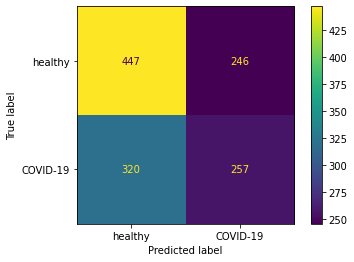

In [271]:
cm_xgb = confusion_matrix(y,y_pred_xgb)
display_labels=['healthy','COVID-19']
ConfusionMatrixDisplay(cm_xgb,display_labels=display_labels).plot(values_format='.0f')

Fully-connected ANN

In [290]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D,MaxPool2D,Dropout,Activation, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow import keras
from tensorflow.keras import layers
#import keras.optimizers.Adam

In [388]:
from keras.models import Sequential
def create_model(optimizer='adam',n_neurons=32,dropout_rates=0.5):
  base_model = Sequential()
  base_model.add(Dense(n_neurons, activation='relu', input_shape=(78,))) #inputlayer and dense
  base_model.add(Dropout(dropout_rates)) #dropout_1
  base_model.add(Dense(n_neurons, activation='relu')) #dense_2
  base_model.add(Dropout(dropout_rates)) #dropout_2
  base_model.add(Dense(1, activation='sigmoid')) #output=dense
  base_model._name = "ANN_model"
  base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
  return base_model
optimizer=optimizer

In [389]:
base_model = KerasClassifier(build_fn=create_model, verbose=0)

In [390]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from joblib import Parallel, delayed
import dill as pickle
from joblibspark import register_spark
import os
os.environ["DATABRICKS_HOST"] = "<YOUR DATABRICKS HOST>"
os.environ["DATABRICKS_TOKEN"] = "<YOUR DATABRICKS TOKEN>"
register_spark()
Parallel(n_jobs=-1, backend="spark")
batch_size=[32,64,128]
epochs=[10,50,100]
optimizer=['SGD','Adam']
neurons=[32,64]
dropout_rates=[0,0.5]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

param_grid=dict(optimizer=optimizer,batch_size=batch_size,epochs=epochs,n_neurons=neurons,dropout_rates=dropout_rates)
grid=GridSearchCV(estimator=base_model,param_grid=param_grid, scoring='accuracy',cv=5, verbose=1)
#grid = GridSearchCV(estimator=base_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(X,y)
#grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
#grid_result = grid_search.fit(X,y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.2min finished


Best: 0.564567 using {'batch_size': 64, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'Adam'}
0.541732 (0.008839) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'SGD'}
0.525197 (0.032043) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'Adam'}
0.540945 (0.033462) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 64, 'optimizer': 'SGD'}
0.550394 (0.028434) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 64, 'optimizer': 'Adam'}
0.534646 (0.026748) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 32, 'optimizer': 'SGD'}
0.533071 (0.030251) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 32, 'optimizer': 'Adam'}
0.525197 (0.028673) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 64, 'optimizer': 'SGD'}
0.522835 (0.028974) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs'

In [ ]:
# BEST RESULT AFTER RUNNING GRIDSEARCH: {'batch_size': 64, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'Adam'}
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=25)
conf_matrix_list_of_arrays = []
X_test=np.zeros((127,78))
X_train=np.zeros((1143,78))
Y_test=[0]*127
Y_train=[0]*1143
for i in range(0,10):
  X_test[:][:]=X[i*127:127*(i+1)][:]
  Y_test[:]=y[i*127:127*(i+1)]
  if i==0:
    X_train[:][:]=X[127:][:]
    Y_train[:]=y[127:]
    #print(X_train.shape)
  elif i>0 or i<9:
    X_train=np.vstack((X[0:127*(i)][:],X[127*(i+1):][:]))
    #Y_train=np.vstack((y[0:127*(i)],y[127*(i+1):]))
    Y_train[:]=np.append(y[0:127*(i)],y[127*(i+1):])
    #print(X_train.shape)
  else:
    X_train[:][:]=X[127*i][:]
    Y_train[:][:]=y[127*i][:]
  base_model = Sequential()
  n_neurons=32
  dropout_rates=0
  base_model.add(Dense(n_neurons, activation='relu', input_shape=(78,))) #inputlayer and dense
  base_model.add(Dropout(dropout_rates)) #dropout_1
  base_model.add(Dense(n_neurons, activation='relu')) #dense_2
  base_model.add(Dropout(dropout_rates)) #dropout_2
  base_model.add(Dense(1, activation='sigmoid')) #output=dense
  base_model._name = "ANN_model"
  base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
  #ANN = base_model(optimizer='adam',n_neurons=32,dropout_rates=0)
  X_train=np.array(X_train)
  Y_train=np.array(Y_train)
  X_val=np.array(X_test)
  Y_val=np.array(Y_test)
  base_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=256,epochs=50)
  #ANN.fit(X_train,Y_train)
  Y_predict=base_model.predict(X_test)
  Y_predict = (Y_predict > 0.5)
  print(Y_predict)
  conf_matrix = confusion_matrix(Y_test, Y_predict)
  conf_matrix_list_of_arrays.append(conf_matrix)

In [430]:
print(conf_matrix_list_of_arrays)
f=0
for i in range(10):
  f+=conf_matrix_list_of_arrays[i][0][0]
print(f)

[array([[45, 31],
       [28, 23]]), array([[41, 33],
       [36, 17]]), array([[48, 22],
       [35, 22]]), array([[27, 31],
       [34, 35]]), array([[47, 28],
       [29, 23]]), array([[45, 24],
       [37, 21]]), array([[44, 27],
       [39, 17]]), array([[47, 24],
       [34, 22]]), array([[44, 23],
       [35, 25]]), array([[41, 21],
       [43, 22]])]
429


In [434]:
#y_pred_ANN =cross_val_score
#y_pred_ANN = (y_pred_ANN > 0.5)
#print(classification_report(y,y_pred_ANN))
#cm_ANN = confusion_matrix(y,y_pred_ANN)
#display_labels=['healthy','COVID-19']
cross_val_predict(estimator=base_model,X=X,cv=5)
#ConfusionMatrixDisplay(cm_ANN,display_labels=display_labels).plot(values_format='.0f')

TypeError: ignored